In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from baseline_clustering import main
import torch
from collections import defaultdict
import numpy as np
import copy
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import gymnasium as gym
import graphviz
import itertools

/home/yanzheb/Development/ASAP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yanzheb/Development/ASAP/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


## Change these if you want

In [3]:
env_id = "MountainCar-v0"
type_ = "activation"
num_clusters = 5

## Results shown in the tables

In [4]:
%run baseline_clustering.py --env-id $env_id --type $type_ --num-clusters $num_clusters
args, fabric, c_instances, envs, (train_b, val_b, test_b) = main(ARGS)
model = c_instances["model"]

Seed set to 0
Seed set to 0


# --- MountainCar-v0 ---
# --- model ---


Seed set to 0


# Silhouette: 0.22633647918701172


Seed set to 0


# Deterministic Action Return - mean: -133.09, std: 33.7100215893665
# Masked Return - mean: -113.06, std: 17.52390574978286
# --- none ---


Seed set to 0


# Silhouette: 0.04490505903959274


Seed set to 0


# Deterministic Action Return - mean: -114.38, std: 1.3542301849904963
# Masked Return - mean: -114.42, std: 19.174467450758627


## t-SNE results

In [5]:
def get_visual_obs(fabric, envs, model, seed, n_episodes: int = 5):
    model = copy.deepcopy(model)
    model.train(False)
    envs = copy.deepcopy(envs)
    fabric.seed_everything(seed)

    done = False
    episode_count = 0
    info = defaultdict(list)
    obs = torch.tensor(envs.reset(seed=seed)[
                       0], device=fabric.device, dtype=torch.float32)

    while episode_count < n_episodes:
        with torch.no_grad():
            _, output, _, _, value = model.agent.get_action_and_value(obs)
            _, _, dist, importance = model(obs)
            c_soft = dist.probs
        if isinstance(envs.single_action_space, gym.spaces.Discrete):
            action = torch.argmax(output, dim=1)
        else:
            action = output
        info["importance"].append(importance)
        cluster_sim, cluster_idx = torch.max(c_soft, dim=1)

        obs = obs.cpu().numpy()
        info["obs"].append(envs.envs[0].get_unnormalized_obs(obs))
        info["obs_norm"].append(obs)
        info["visual_obs"].append(
            envs.envs[0].unwrapped.render()[np.newaxis, ...])

        next_obs, _, terminated, truncated, _ = envs.step(
            action.numpy(force=True))
        done = np.logical_or(terminated, truncated)
        obs = torch.tensor(next_obs, device=fabric.device, dtype=torch.float32)

        info["cluster"].append(cluster_idx.cpu().numpy())
        info["output"].append(output.cpu().numpy())
        info["value"].append(value.squeeze(1).cpu().numpy())

        info["cluster_sim"].append(cluster_sim.cpu().numpy())

        if done.item():
            episode_count += 1
            # obs = torch.tensor(envs.reset(seed=episode_count)[0], device=fabric.device, dtype=torch.float32)

    info = {key: np.concatenate(value, axis=0) for key, value in info.items()}

    # Shuffle the items
    # p = np.random.permutation(len(info["obs"]))
    # info = {key: value[p] for key, value in info.items()}

    return info

In [6]:
info = get_visual_obs(fabric, envs, model, 0, 100)

Seed set to 0


<Axes: xlabel='Dim 1', ylabel='Dim 2'>

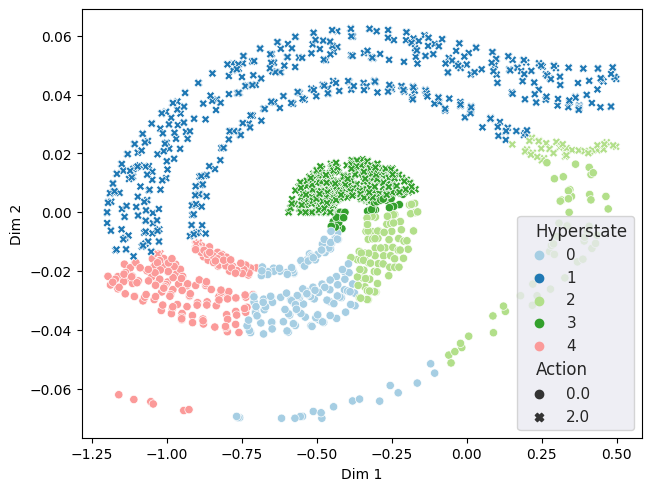

In [7]:
if env_id == "MountainCar-v0":
    X_embedded = info["obs"]
else:
    X_embedded = TSNE(n_components=2, random_state=0).fit_transform(
        info["obs_norm"])

obs = pd.DataFrame(np.concatenate((X_embedded, info["cluster"][..., np.newaxis], np.argmax(info["output"], axis=1, keepdims=True)), axis=1),
                   columns=("Dim 1", "Dim 2", "Hyperstate", "Action"))
obs["Hyperstate"] = obs["Hyperstate"].astype(int)


fig, ax = plt.subplots(constrained_layout=True)
sns.set_theme()
sns.set(font_scale=1)
sns.scatterplot(obs.sample(n=1_500, random_state=0), x="Dim 1",
                y="Dim 2", hue="Hyperstate", palette="Paired", style=None if env_id == "Swimmer-v4" else "Action", ax=ax)

## Markov chain visualization

In [8]:
def evaluate_model(local_envs, model, n_episodes: int, mode: str, n_clusters: int, seed: int, device: torch.device):
    # cluster transition matrix, row = from, col = to
    cluster_transition_m = torch.zeros((n_clusters, n_clusters), device=device)
    # cluster transition
    cluster_transition = [[]]
    # episode info
    ep_info = defaultdict(list)

    prev_cluster = None
    current_ep = 0

    # prepare run
    model.train(False)
    model = copy.deepcopy(model)
    fabric.seed_everything(seed)
    local_envs = copy.deepcopy(local_envs)
    obs = local_envs.reset(seed=seed)[0]

    while current_ep < n_episodes:
        obs = torch.tensor(obs, device=device, dtype=torch.float)
        if mode == "bottleneck":
            action, output, dist, _, = model(obs, False)
        else:
            action, output, _, _, _ = model.agent.get_action_and_value(obs)
            if isinstance(local_envs.single_action_space, gym.spaces.Discrete):
                action = torch.argmax(output, dim=1)
            else:
                action = output
        action = action.numpy(force=True)
        if isinstance(local_envs.single_action_space, gym.spaces.Discrete):
            ep_info["action"].append(
                F.softmax(output, dim=1).numpy(force=True))
        else:
            ep_info["action"].append(output.numpy(force=True))

        next_obs, _, terminated, truncated, infos = local_envs.step(action)
        obs = next_obs

        if mode == "bottleneck":
            cluster_transition[-1].append(dist.probs)

            cluster = torch.argmax(dist.probs, dim=1)
            if prev_cluster is not None:
                cluster_transition_m[prev_cluster, cluster] += 1
            prev_cluster = cluster

            ep_info["cluster_y"].append(cluster)

        # Only print when at least 1 env is done
        if "final_info" not in infos:
            continue

        for info in infos["final_info"]:
            # Skip the envs that are not done
            if info is None:
                continue
            ep_info["ep_length"].append(info["episode"]["l"].item())
            ep_info["ep_reward"].append(info["episode"]["r"].item())
            current_ep += 1
            # obs = envs.reset(seed=current_ep)[0]
            if current_ep < n_episodes:
                cluster_transition.append([])
            prev_cluster = None

    if mode == "bottleneck":
        ep_info["cluster_y"] = [
            torch.cat(ep_info["cluster_y"]).int().detach().cpu().numpy()]
        cluster_transition = [torch.cat(ep, dim=0)
                              for ep in cluster_transition]
        ep_info["action"] = [np.concatenate(ep_info["action"], axis=0)]
    return {"cluster_transition_m": cluster_transition_m,
            "cluster_transition": cluster_transition} | ep_info

In [9]:
seed = 0
n_episodes = 100
bottleneck_info = evaluate_model(
    envs, model, n_episodes, "bottleneck", model.n_clusters, args.seed, fabric.device)
no_bottleneck_info = evaluate_model(
    envs, model, n_episodes, "none", model.n_clusters, args.seed, fabric.device)

Seed set to 0
Seed set to 0


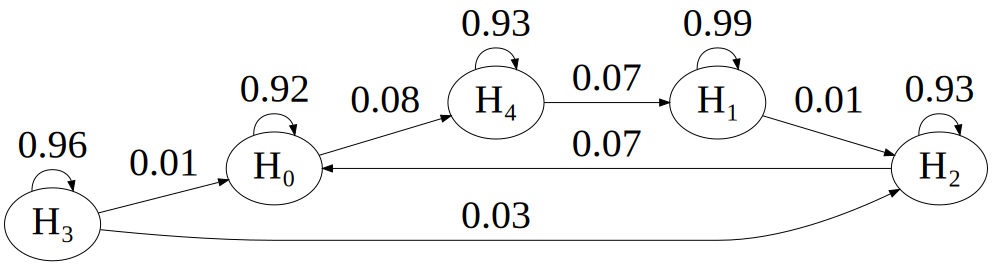

In [10]:
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
dot = graphviz.Digraph(graph_attr={'rankdir': 'LR'}, engine="dot")
transition_matrix = bottleneck_info["cluster_transition_m"]
transition_matrix = transition_matrix / \
    (transition_matrix.sum(1, keepdim=True) + 1e-8)

cluster = range(model.n_clusters)
filter_threshold = 0.02 if env_id == "FlappyBird-v0" else 0.00
fontsize = "40"

for i in cluster:
    dot.node(f"H{i}".translate(SUB), fontsize=fontsize)

for i, j in itertools.product(cluster, cluster):
    if transition_matrix[i, j] < filter_threshold or transition_matrix[i, j] == 0:
        continue
    dot.edge(f"H{i}".translate(SUB), f"H{j}".translate(SUB),
             label=f"{transition_matrix[i, j]:.2f}", fontsize=fontsize)
    # dot.edge(f"H{i}", f"H{j}", color=color)

dot